In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v7 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-12 14:31:56.782131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 14:31:56.782420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 14:31:56.839961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 14:31:56.840261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 14:31:56.840603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # autoencoder directory
    ae_idx = '020'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

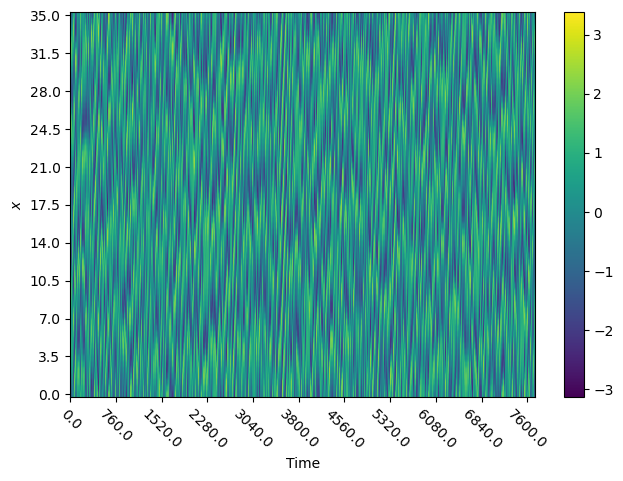

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

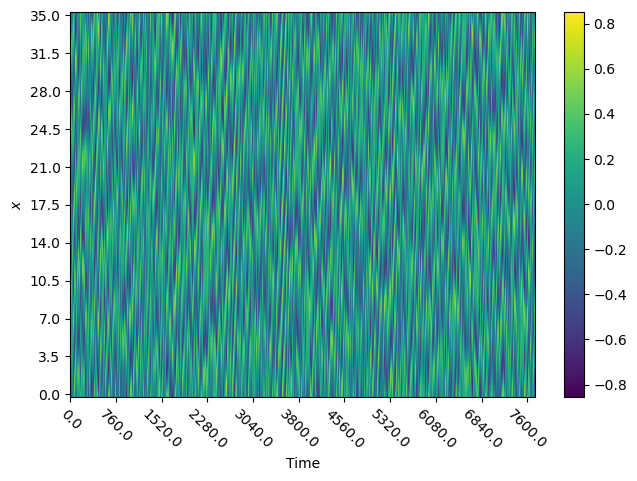

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

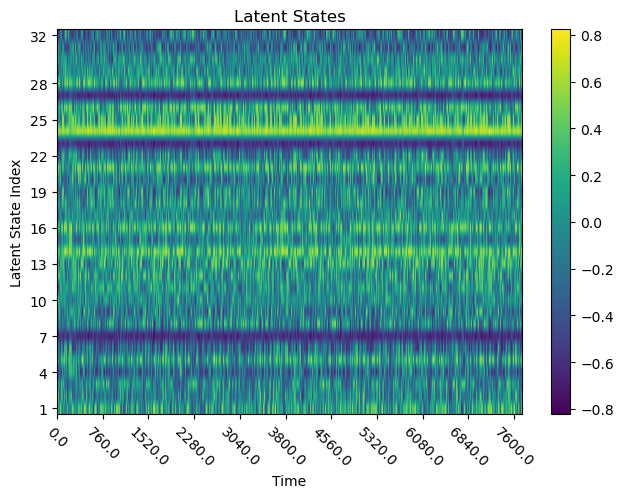

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 1/3
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [29]:
del(data_rnn_input)
del(data_rnn_output)

In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**8]*2
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    stddev = fRMS*timeMeanofSpaceRMS
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func='linear',
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func='linear',
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.40322953
stddev : 0.010080738365650177


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
4/4 [==============================] - ETA: 0s - loss: 0.1959 - tot_time: 0h 3m 23.6s

Epoch 1: val_loss improved from inf to 0.14038, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 204s 10s/step - loss: 0.1959 - val_loss: 0.1404
Epoch 2/2000
4/4 [==============================] - ETA: 0s - loss: 0.1281 - tot_time: 0h 3m 25.5s

Epoch 2: val_loss improved from 0.14038 to 0.11566, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Do

Epoch 18/2000
4/4 [==============================] - ETA: 0s - loss: 0.0664 - tot_time: 0h 3m 56.3s

Epoch 18: val_loss improved from 0.06692 to 0.06583, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 501ms/step - loss: 0.0664 - val_loss: 0.0658
Epoch 19/2000
4/4 [==============================] - ETA: 0s - loss: 0.0654 - tot_time: 0h 3m 58.1s

Epoch 19: val_loss improved from 0.06583 to 0.06479, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 470ms/step - loss: 0.0654 - val_loss: 0.0648
Epoch 20/2000
4/4 [==============================] - ETA: 0s - loss: 0.0644 

Epoch 36/2000
4/4 [==============================] - ETA: 0s - loss: 0.0529 - tot_time: 0h 4m 30.7s

Epoch 36: val_loss improved from 0.05318 to 0.05260, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 505ms/step - loss: 0.0529 - val_loss: 0.0526
Epoch 37/2000
4/4 [==============================] - ETA: 0s - loss: 0.0523 - tot_time: 0h 4m 32.6s

Epoch 37: val_loss improved from 0.05260 to 0.05205, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0523 - val_loss: 0.0521
Epoch 38/2000
4/4 [==============================] - ETA: 0s - loss: 0.0518 

Epoch 54/2000
4/4 [==============================] - ETA: 0s - loss: 0.0441 - tot_time: 0h 5m 5.2s

Epoch 54: val_loss improved from 0.04430 to 0.04388, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 504ms/step - loss: 0.0441 - val_loss: 0.0439
Epoch 55/2000
4/4 [==============================] - ETA: 0s - loss: 0.0437 - tot_time: 0h 5m 7.1s

Epoch 55: val_loss improved from 0.04388 to 0.04346, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0437 - val_loss: 0.0435
Epoch 56/2000
4/4 [==============================] - ETA: 0s - loss: 0.0433 - 

Epoch 72/2000
4/4 [==============================] - ETA: 0s - loss: 0.0375 - tot_time: 0h 5m 39.6s

Epoch 72: val_loss improved from 0.03769 to 0.03737, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 513ms/step - loss: 0.0375 - val_loss: 0.0374
Epoch 73/2000
4/4 [==============================] - ETA: 0s - loss: 0.0372 - tot_time: 0h 5m 41.5s

Epoch 73: val_loss improved from 0.03737 to 0.03703, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0372 - val_loss: 0.0370
Epoch 74/2000
4/4 [==============================] - ETA: 0s - loss: 0.0369 

Epoch 90/2000
4/4 [==============================] - ETA: 0s - loss: 0.0324 - tot_time: 0h 6m 14.0s

Epoch 90: val_loss improved from 0.03254 to 0.03227, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 493ms/step - loss: 0.0324 - val_loss: 0.0323
Epoch 91/2000
4/4 [==============================] - ETA: 0s - loss: 0.0321 - tot_time: 0h 6m 15.9s

Epoch 91: val_loss improved from 0.03227 to 0.03203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0321 - val_loss: 0.0320
Epoch 92/2000
4/4 [==============================] - ETA: 0s - loss: 0.0319 

Epoch 108/2000
4/4 [==============================] - ETA: 0s - loss: 0.0286 - tot_time: 0h 6m 48.7s

Epoch 108: val_loss did not improve from 0.02858
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0286 - val_loss: 0.0289
Epoch 109/2000
4/4 [==============================] - ETA: 0s - loss: 0.0285 - tot_time: 0h 6m 50.5s

Epoch 109: val_loss improved from 0.02858 to 0.02838, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 498ms/step - loss: 0.0285 - val_loss: 0.0284
Epoch 110/2000
4/4 [==============================] - ETA: 0s - loss: 0.0282 - tot_time: 0h 6m 52.5s

Epoch 110: val_loss improved from 0.02838 to 0.02810, saving model to /ho

4/4 [==============================] - ETA: 0s - loss: 0.0250 - tot_time: 0h 7m 23.0s

Epoch 126: val_loss improved from 0.02515 to 0.02498, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 491ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 127/2000
4/4 [==============================] - ETA: 0s - loss: 0.0248 - tot_time: 0h 7m 24.9s

Epoch 127: val_loss improved from 0.02498 to 0.02483, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 482ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 128/2000
4/4 [==============================] - ETA: 0s - loss: 0.0247 - tot_time

Epoch 144/2000
4/4 [==============================] - ETA: 0s - loss: 0.0222 - tot_time: 0h 7m 57.3s

Epoch 144: val_loss improved from 0.02235 to 0.02216, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 479ms/step - loss: 0.0222 - val_loss: 0.0222
Epoch 145/2000
4/4 [==============================] - ETA: 0s - loss: 0.0220 - tot_time: 0h 7m 59.2s

Epoch 145: val_loss improved from 0.02216 to 0.02208, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 485ms/step - loss: 0.0220 - val_loss: 0.0221
Epoch 146/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 162/2000
4/4 [==============================] - ETA: 0s - loss: 0.0198 - tot_time: 0h 8m 31.5s

Epoch 162: val_loss improved from 0.01999 to 0.01978, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 486ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 163/2000
4/4 [==============================] - ETA: 0s - loss: 0.0196 - tot_time: 0h 8m 33.4s

Epoch 163: val_loss improved from 0.01978 to 0.01963, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 499ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 164/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 180/2000
4/4 [==============================] - ETA: 0s - loss: 0.0176 - tot_time: 0h 9m 5.7s

Epoch 180: val_loss improved from 0.01773 to 0.01762, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 483ms/step - loss: 0.0176 - val_loss: 0.0176
Epoch 181/2000
4/4 [==============================] - ETA: 0s - loss: 0.0175 - tot_time: 0h 9m 7.6s

Epoch 181: val_loss improved from 0.01762 to 0.01754, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 485ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 182/2000
4/4 [==============================] - ETA: 0s - loss: 0.01

Epoch 198/2000
4/4 [==============================] - ETA: 0s - loss: 0.0158 - tot_time: 0h 9m 40.0s

Epoch 198: val_loss improved from 0.01589 to 0.01584, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 495ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 199/2000
4/4 [==============================] - ETA: 0s - loss: 0.0157 - tot_time: 0h 9m 42.0s

Epoch 199: val_loss improved from 0.01584 to 0.01573, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 494ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 200/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 216/2000
4/4 [==============================] - ETA: 0s - loss: 0.0141 - tot_time: 0h 10m 14.4s

Epoch 216: val_loss improved from 0.01426 to 0.01418, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 486ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 217/2000
4/4 [==============================] - ETA: 0s - loss: 0.0140 - tot_time: 0h 10m 16.3s

Epoch 217: val_loss improved from 0.01418 to 0.01409, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 490ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 218/2000
4/4 [==============================] - ETA: 0s - loss: 

Epoch 234/2000
4/4 [==============================] - ETA: 0s - loss: 0.0127 - tot_time: 0h 10m 48.6s

Epoch 234: val_loss improved from 0.01286 to 0.01273, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 494ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 235/2000
4/4 [==============================] - ETA: 0s - loss: 0.0126 - tot_time: 0h 10m 50.5s

Epoch 235: val_loss improved from 0.01273 to 0.01272, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 483ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 236/2000
4/4 [==============================] - ETA: 0s - loss: 

Epoch 252/2000
4/4 [==============================] - ETA: 0s - loss: 0.0114 - tot_time: 0h 11m 22.9s

Epoch 252: val_loss improved from 0.01158 to 0.01145, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 487ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 253/2000
4/4 [==============================] - ETA: 0s - loss: 0.0113 - tot_time: 0h 11m 24.8s

Epoch 253: val_loss improved from 0.01145 to 0.01141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 488ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 254/2000
4/4 [==============================] - ETA: 0s - loss: 

Epoch 270/2000
4/4 [==============================] - ETA: 0s - loss: 0.0102 - tot_time: 0h 11m 57.2s

Epoch 270: val_loss improved from 0.01034 to 0.01028, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 505ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 271/2000
4/4 [==============================] - ETA: 0s - loss: 0.0101 - tot_time: 0h 11m 59.1s

Epoch 271: val_loss improved from 0.01028 to 0.01023, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 508ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 272/2000
4/4 [==============================] - ETA: 0s - loss: 

4/4 [==============================] - ETA: 0s - loss: 0.0092 - tot_time: 0h 12m 31.3s

Epoch 288: val_loss improved from 0.00940 to 0.00939, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 488ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 289/2000
4/4 [==============================] - ETA: 0s - loss: 0.0092 - tot_time: 0h 12m 33.1s

Epoch 289: val_loss improved from 0.00939 to 0.00926, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 481ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 290/2000
4/4 [==============================] - ETA: 0s - loss: 0.0091 - tot_ti

Epoch 306/2000
4/4 [==============================] - ETA: 0s - loss: 0.0083 - tot_time: 0h 13m 5.3s

Epoch 306: val_loss improved from 0.00844 to 0.00838, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 483ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 307/2000
4/4 [==============================] - ETA: 0s - loss: 0.0082 - tot_time: 0h 13m 7.2s

Epoch 307: val_loss improved from 0.00838 to 0.00834, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 504ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 308/2000
4/4 [==============================] - ETA: 0s - loss: 0.

Epoch 324/2000
4/4 [==============================] - ETA: 0s - loss: 0.0075 - tot_time: 0h 13m 39.5s

Epoch 324: val_loss improved from 0.00766 to 0.00759, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 495ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 325/2000
4/4 [==============================] - ETA: 0s - loss: 0.0074 - tot_time: 0h 13m 41.4s

Epoch 325: val_loss improved from 0.00759 to 0.00758, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 499ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 326/2000
4/4 [==============================] - ETA: 0s - loss: 

Epoch 342/2000
4/4 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 14m 13.6s

Epoch 342: val_loss improved from 0.00690 to 0.00688, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 343/2000
4/4 [==============================] - ETA: 0s - loss: 0.0067 - tot_time: 0h 14m 15.5s

Epoch 343: val_loss improved from 0.00688 to 0.00680, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 493ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 344/2000
4/4 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 361/2000
4/4 [==============================] - ETA: 0s - loss: 0.0061 - tot_time: 0h 14m 49.6s

Epoch 361: val_loss improved from 0.00626 to 0.00621, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 473ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 362/2000
4/4 [==============================] - ETA: 0s - loss: 0.0060 - tot_time: 0h 14m 51.5s

Epoch 362: val_loss improved from 0.00621 to 0.00615, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 491ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 379/2000
4/4 [==============================] - ETA: 0s - loss: 0.0055 - tot_time: 0h 15m 24.0s

Epoch 379: val_loss improved from 0.00565 to 0.00564, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 481ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 380/2000
4/4 [==============================] - ETA: 0s - loss: 0.0055 - tot_time: 0h 15m 25.9s

Epoch 380: val_loss did not improve from 0.00564
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/st

Epoch 398/2000
4/4 [==============================] - ETA: 0s - loss: 0.0051 - tot_time: 0h 15m 59.7s

Epoch 398: val_loss improved from 0.00523 to 0.00513, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 504ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 399/2000
4/4 [==============================] - ETA: 0s - loss: 0.0050 - tot_time: 0h 16m 1.6s

Epoch 399: val_loss did not improve from 0.00513
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 460ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 400/2000
4/4 [==============================] - ETA: 0s - loss: 0.0050 - tot_time: 0h 16m 3.5s

Epoch 400: val_loss improved from 0.00513 to 0.00510, saving model to /h

4/4 [==============================] - ETA: 0s - loss: 0.0045 - tot_time: 0h 16m 34.2s

Epoch 416: val_loss improved from 0.00467 to 0.00461, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 497ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 417/2000
4/4 [==============================] - ETA: 0s - loss: 0.0045 - tot_time: 0h 16m 36.1s

Epoch 417: val_loss did not improve from 0.00461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 468ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 418/2000
4/4 [==============================] - ETA: 0s - loss: 0.0045 - tot_time: 0h 16m 38.0s

Epoch 418: val_loss did not improve from 0.00461
 - saving loss histories at /home/rk

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 511ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 436/2000
4/4 [==============================] - ETA: 0s - loss: 0.0041 - tot_time: 0h 17m 12.3s

Epoch 436: val_loss improved from 0.00425 to 0.00420, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 495ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 437/2000
4/4 [==============================] - ETA: 0s - loss: 0.0041 - tot_time: 0h 17m 14.2s

Epoch 437: val_loss did not improve from 0.00420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 478ms/st

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 511ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 456/2000
4/4 [==============================] - ETA: 0s - loss: 0.0038 - tot_time: 0h 17m 50.0s

Epoch 456: val_loss improved from 0.00394 to 0.00393, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 493ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 457/2000
4/4 [==============================] - ETA: 0s - loss: 0.0038 - tot_time: 0h 17m 52.0s

Epoch 457: val_loss did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 475ms/st

Epoch 475/2000
4/4 [==============================] - ETA: 0s - loss: 0.0034 - tot_time: 0h 18m 26.1s

Epoch 475: val_loss improved from 0.00354 to 0.00350, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 474ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 476/2000
4/4 [==============================] - ETA: 0s - loss: 0.0033 - tot_time: 0h 18m 28.0s

Epoch 476: val_loss improved from 0.00350 to 0.00348, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 490ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 477/2000
4/4 [==============================] - ETA: 0s - loss: 

4/4 [==============================] - ETA: 0s - loss: 0.0031 - tot_time: 0h 19m 4.0s

Epoch 495: val_loss improved from 0.00325 to 0.00324, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 490ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 496/2000
4/4 [==============================] - ETA: 0s - loss: 0.0031 - tot_time: 0h 19m 5.9s

Epoch 496: val_loss improved from 0.00324 to 0.00323, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 510ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 497/2000
4/4 [==============================] - ETA: 0s - loss: 0.0031 - tot_time

Epoch 514/2000
4/4 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 19m 40.2s

Epoch 514: val_loss improved from 0.00305 to 0.00303, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 515/2000
4/4 [==============================] - ETA: 0s - loss: 0.0028 - tot_time: 0h 19m 42.1s

Epoch 515: val_loss improved from 0.00303 to 0.00302, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 491ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 516/2000
4/4 [==============================] - ETA: 0s - loss: 

Epoch 534/2000
4/4 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 20m 18.0s

Epoch 534: val_loss improved from 0.00285 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 535/2000
4/4 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 20m 19.9s

Epoch 535: val_loss did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 478ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 536/2000
4/4 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 20m 21.9s

Epoch 536: val_loss did not improve from 0.00283
 - saving loss histor

4/4 [==============================] - ETA: 0s - loss: 0.0025 - tot_time: 0h 20m 55.7s

Epoch 554: val_loss improved from 0.00264 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 494ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 555/2000
4/4 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 20m 57.6s

Epoch 555: val_loss did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 556/2000
4/4 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 20m 59.4s

Epoch 556: val_loss did not improve from 0.00261
 - saving loss histories at /home/rk

Epoch 575/2000
4/4 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 21m 34.6s

Epoch 575: val_loss did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 576/2000
4/4 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 21m 36.4s

Epoch 576: val_loss did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 474ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 577/2000
4/4 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 21m 38.3s

Epoch 577: val_loss did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4

Epoch 595/2000
4/4 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 22m 12.3s

Epoch 595: val_loss improved from 0.00230 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 494ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 596/2000
4/4 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 22m 14.2s

Epoch 596: val_loss did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 466ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 597/2000
4/4 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 22m 16.1s

Epoch 597: val_loss improved from 0.00229 to 0.00229, saving model to 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 493ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 616/2000
4/4 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 22m 51.7s

Epoch 616: val_loss improved from 0.00219 to 0.00218, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 499ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 617/2000
4/4 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 22m 53.6s

Epoch 617: val_loss improved from 0.00218 to 0.00216, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 637/2000
4/4 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 23m 30.9s

Epoch 637: val_loss did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 638/2000
4/4 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 23m 32.8s

Epoch 638: val_loss did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 472ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 639/2000
4/4 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 23m 34.6s

Epoch 639: val_loss did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4

4/4 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 24m 8.6s

Epoch 657: val_loss did not improve from 0.00201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 480ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 658/2000
4/4 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 24m 10.5s

Epoch 658: val_loss improved from 0.00201 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 485ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 659/2000
4/4 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 24m 12.4s

Epoch 659: val_loss did not improve from 0.00198
 - saving loss histories at /home/rka

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 679/2000
4/4 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 24m 49.8s

Epoch 679: val_loss did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 680/2000
4/4 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 24m 51.7s

Epoch 680: val_loss did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 474ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 681/2000
4/4 [==============================] - ETA: 0s - lo

4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 25m 27.3s

Epoch 699: val_loss did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 489ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 700/2000
4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 25m 29.1s

Epoch 700: val_loss did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 701/2000
4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 25m 31.0s

Epoch 701: val_loss did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [===========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 495ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 722/2000
4/4 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 26m 10.1s

Epoch 722: val_loss improved from 0.00183 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 505ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 723/2000
4/4 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 26m 12.0s

Epoch 723: val_loss improved from 0.00182 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 744/2000
4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 26m 50.8s

Epoch 744: val_loss did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 745/2000
4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 26m 52.6s

Epoch 745: val_loss did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 472ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 746/2000
4/4 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 26m 54.5s

Epoch 746: val_loss did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4

Epoch 16/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 27m 28.1s

Epoch 16: val_loss did not improve from 0.00173
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 462ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 17/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 27m 30.0s

Epoch 17: val_loss did not improve from 0.00173
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 472ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 18/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 27m 31.8s

Epoch 18: val_loss improved from 0.00173 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at

4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 7.1s

Epoch 37: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 464ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 38/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 9.0s

Epoch 38: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 39/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 10.8s

Epoch 39: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==================

4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 46.3s

Epoch 58: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 480ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 59/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 48.2s

Epoch 59: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 461ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 60/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 28m 50.0s

Epoch 60: val_loss improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushi

4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 29m 25.5s

Epoch 79: val_loss improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 494ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 80/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 29m 27.4s

Epoch 80: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 488ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 81/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 29m 29.3s

Epoch 81: val_loss improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Docum

Epoch 100/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 4.8s

Epoch 100: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 463ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 101/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 6.6s

Epoch 101: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 468ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 102/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 8.4s

Epoch 102: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 

Epoch 121/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 44.0s

Epoch 121: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 470ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 122/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 45.8s

Epoch 122: val_loss improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 478ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 123/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 30m 47.7s

Epoch 123: val_loss did not improve from 0.00171
 - saving loss histor

Epoch 142/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 31m 22.9s

Epoch 142: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 143/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 31m 24.8s

Epoch 143: val_loss did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 481ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 144/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 31m 26.6s

Epoch 144: val_loss improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histor

Epoch 164/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 32m 3.8s

Epoch 164: val_loss improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 512ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 165/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 32m 5.7s

Epoch 165: val_loss did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 463ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 166/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 32m 7.6s

Epoch 166: val_loss did not improve from 0.00170
 - saving loss histories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 496ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 186/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 32m 44.9s

Epoch 186: val_loss did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 475ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 187/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 32m 46.7s

Epoch 187: val_loss did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 485ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 188/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 207/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 33m 23.9s

Epoch 207: val_loss improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 498ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 208/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 33m 25.8s

Epoch 208: val_loss did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 470ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 209/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 33m 27.6s

Epoch 209: val_loss improved from 0.00170 to 0.00169, saving model to 

Epoch 229/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 34m 4.5s

Epoch 229: val_loss did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 465ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 230/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 34m 6.4s

Epoch 230: val_loss did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 478ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 231/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 34m 8.2s

Epoch 231: val_loss improved from 0.00169 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 250/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 34m 43.8s

Epoch 250: val_loss did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 251/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 34m 45.6s

Epoch 251: val_loss did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 473ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 252/2000
4/4 [==============================] - ETA: 0s - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 272/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 35m 24.5s

Epoch 272: val_loss did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 466ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 273/2000
4/4 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 35m 26.3s

Epoch 273: val_loss did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 472ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 274/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 293/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 3.5s

Epoch 293: val_loss improved from 0.00168 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 473ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 294/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 5.4s

Epoch 294: val_loss did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 474ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 295/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 7.2s

Epoch 295: val_loss did not improve from 0.00168
 - saving loss histories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 501ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 314/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 42.8s

Epoch 314: val_loss did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 484ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 315/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 44.7s

Epoch 315: val_loss did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 481ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 316/2000
4/4 [==============================] - ETA: 0s - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 481ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 336/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 37m 23.8s

Epoch 336: val_loss did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 471ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 337/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 37m 25.6s

Epoch 337: val_loss did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 338/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 357/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 38m 2.8s

Epoch 357: val_loss improved from 0.00167 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 358/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 38m 4.7s

Epoch 358: val_loss improved from 0.00167 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 503ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 359/2000
4/4 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 474ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 379/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 38m 43.4s

Epoch 379: val_loss did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 457ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 380/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 38m 45.3s

Epoch 380: val_loss did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 468ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 381/2000
4/4 [==============================] - ETA: 0s - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 477ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 400/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 22.2s

Epoch 400: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 401/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 24.0s

Epoch 401: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 456ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 402/2000
4/4 [==============================] - ETA: 0s - lo

4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 0.6s

Epoch 421: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 468ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 422/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 2.5s

Epoch 422: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 423/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 4.4s

Epoch 423: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============

Epoch 442/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 39.9s

Epoch 442: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 467ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 443/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 41.7s

Epoch 443: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 469ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 444/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 43.5s

Epoch 444: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4

Epoch 464/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 20.4s

Epoch 464: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 461ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 465/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 22.2s

Epoch 465: val_loss did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 463ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 466/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 24.1s

Epoch 466: val_loss improved from 0.00166 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histor

Epoch 486/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 0.8s

Epoch 486: val_loss did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 457ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 487/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 2.6s

Epoch 487: val_loss did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 463ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 488/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 4.4s

Epoch 488: val_loss did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 461ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 509/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 42.5s

Epoch 509: val_loss did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 457ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 510/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 44.3s

Epoch 510: val_loss did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 464ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 511/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 531/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 43m 23.0s

Epoch 531: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 479ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 532/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 43m 24.8s

Epoch 532: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 465ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 533/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 43m 26.7s

Epoch 533: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4

Epoch 553/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 3.6s

Epoch 553: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 461ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 554/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 5.4s

Epoch 554: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 462ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 555/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 7.2s

Epoch 555: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 460ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 576/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 45.4s

Epoch 576: val_loss improved from 0.00164 to 0.00164, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 476ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 577/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 47.2s

Epoch 577: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 458ms/st

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 467ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 598/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 45m 25.6s

Epoch 598: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 464ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 599/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 45m 27.4s

Epoch 599: val_loss did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 461ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 600/2000
4/4 [==============================] - ETA: 0s - lo

Epoch 5/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 3.8s

Epoch 5: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 462ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 5.6s

Epoch 6: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 458ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 7.5s

Epoch 7: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [===========

Epoch 28/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 45.6s

Epoch 28: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 473ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 29/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 47.4s

Epoch 29: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_028/checkpoints/LossHistoriesCheckpoint
4/4 [==============================] - 2s 457ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 30/2000
4/4 [==============================] - ETA: 0s - loss: 0.0014Restoring model weights from the end of the best epoch: 5.
 - tot_time: 0h 46m 49.2s

Epoch 30: val_loss did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sa

In [33]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1/1 [==============================] - 0s 142ms/step - loss: 0.0017


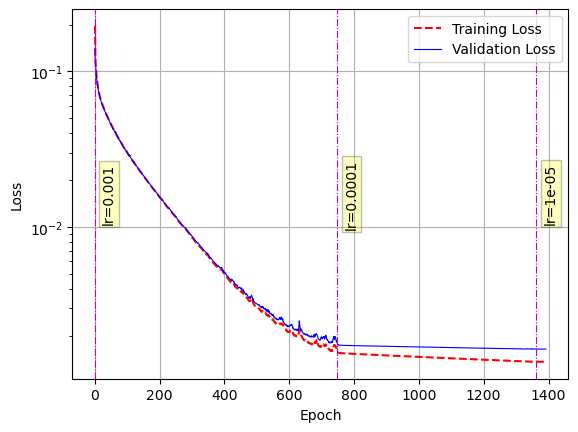

In [34]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 26


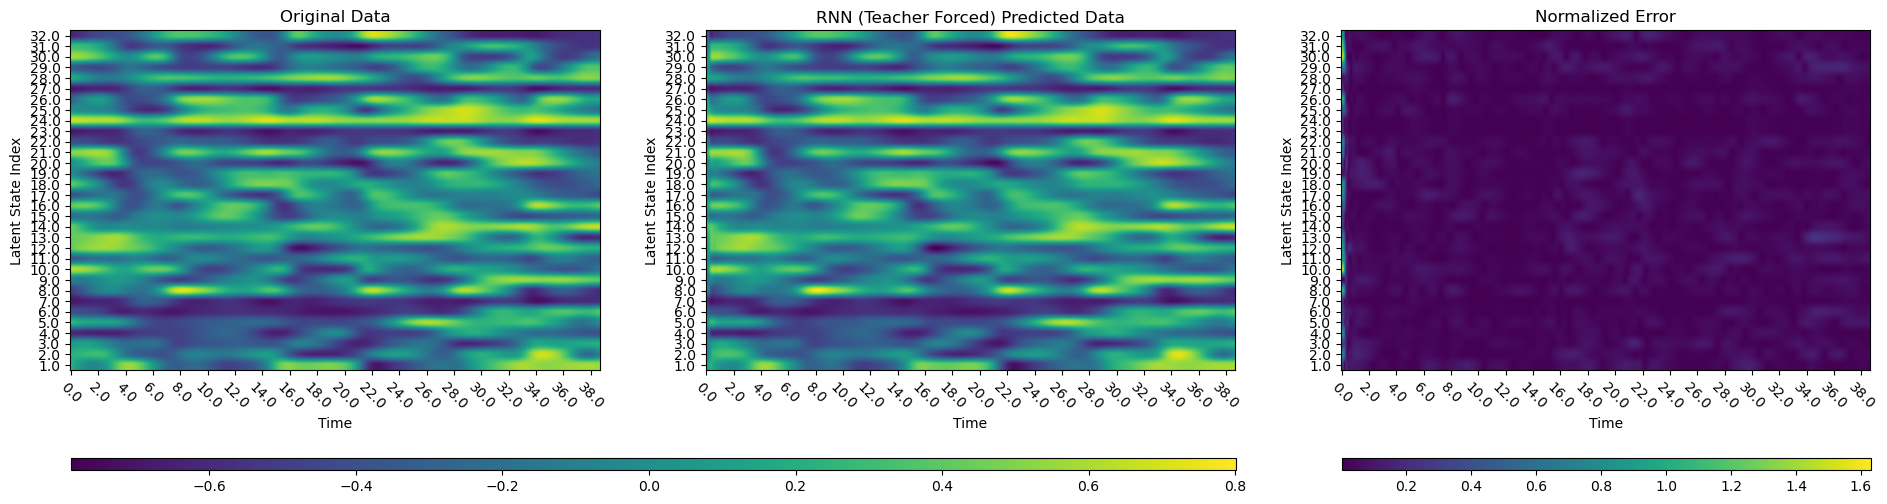

In [35]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [36]:
prediction.shape, data_out.shape

((1, 387, 32), (387, 32))